# Data
Download the IMDB reviews if its not already in the local cache.
Load from the local cache and split to train and test sets.

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [12]:
import os
import ssl
from keras.utils import get_file
try:
    from notebooks.data import load_imdb
except ModuleNotFoundError:
    from data import load_imdb

if (not os.environ.get('PYTHONHTTPSVERIFY', '')
        and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

zip_file = get_file('aclImdb.zip', origin='http://mng.bz/0tIo', extract=True)
imdb_dir = zip_file.replace('.zip', '')
(train_texts, train_labels), (test_texts, test_labels) = load_imdb(imdb_dir)

print('An example from the reviews:')
print('============================')
print(f'Text : {train_texts[0][:200]}...')
print(f'Label: {train_labels[0]}')

An example from the reviews:
Text : If you are expecting to see a lot in the bath of Alt&#305;oklar, as it is promised by the tag line, you will be very disappointed to see that the movie consists of nothing but the populist style of Al...
Label: neg


# Prepare Data
Initialize a `WordVectorizer`. The vectorizer will be fitted on the 
`train_texts`. We won't use any word tokenizer, so the words will be splitted
on spaces and keep the `num_words` most common words.

In [13]:
from keras_nlp import WordVectorizer

num_words = 50000
word_vectorizer = WordVectorizer(num_words=num_words, oov_token='UNK')
word_vectorizer.fit_on_texts(train_texts)
# The vectorizer's number of tokens num_words + PAD + OOV token
print(f'Vectorizer number of tokens: {word_vectorizer.num_tokens}')

2020-Feb-02 22:28:52 [INFO    :WordVectorizer] - Creating vocabulary.


25000/25000 [==============================] - 3s 136us/step
Vectorizer number of tokens: 50002


## Encode Labels
The labels are strings ('pos' / 'neg'). We will convert them to numbers.

In [14]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(train_labels, classes=['neg', 'pos'])
y_test = label_binarize(test_labels, classes=['neg', 'pos'])

## Keep a Validation Set

In [15]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, y_train, y_val = train_test_split(
    train_texts, y_train, stratify=train_labels, random_state=45)

## Create Generators for Vectorized Data
We use the `texts_to_vectors_generator` method. The generator expects the 
texts, the labels and other parameters such as `shape` and `batch_size`.
For the `shape` we define to be `max_tokens` per sentences.

**Attention**: We *must* pass the same number of `max_tokens` when 
converting different text sets (train, validation, test). 
If we don't, then it is almost certain that the results will have different 
numbers of columns because the set are likely to have different number of tokens.
We create *generators* for the train, validation and test text sets.


In [16]:
max_tokens = 500
batch_size = 32
train_generator = word_vectorizer.texts_to_vectors_generator(
    train_texts, y_train, shape=(max_tokens,), batch_size=batch_size)
val_generator = word_vectorizer.texts_to_vectors_generator(
    val_texts, y_val, shape=(max_tokens,), batch_size=batch_size)

# Neural Network
Here we define a toy network for demonstration purpose.

In [17]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense

words_input = Input(shape=(max_tokens, ), name='Input', dtype='int32')
words_embeddings = Embedding(
    input_dim=len(word_vectorizer.token2id),
    output_dim=100,
    input_length=max_tokens,
    mask_zero=0,
    trainable=True,
    name='Embeddings')(words_input)
x = Flatten(name='Flatten')(words_embeddings)
predictions = Dense(1, activation='sigmoid', name='Predictions')(x)
model = Model(words_input, predictions)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 500)               0         
_________________________________________________________________
Embeddings (Embedding)       (None, 500, 100)          5000200   
_________________________________________________________________
Flatten (Flatten)            (None, 50000)             0         
_________________________________________________________________
Predictions (Dense)          (None, 1)                 50001     
Total params: 5,050,201
Trainable params: 5,050,201
Non-trainable params: 0
_________________________________________________________________
None


## Train Model

In [18]:
steps_per_epoch = len(train_texts) // batch_size
if steps_per_epoch % batch_size:
    steps_per_epoch += 1
val_steps_per_epoch = len(val_texts) // batch_size
if val_steps_per_epoch % batch_size:
    val_steps_per_epoch += 1

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit_generator(
                    generator=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=5)

Epoch 1/5
586/586 [==============================] - 8s 13ms/step - loss: 0.4278 - acc: 0.7957 - val_loss: 0.3004 - val_acc: 0.8699
Epoch 2/5
586/586 [==============================] - 7s 12ms/step - loss: 0.1200 - acc: 0.9621 - val_loss: 0.2802 - val_acc: 0.8824
Epoch 3/5
586/586 [==============================] - 7s 12ms/step - loss: 0.0299 - acc: 0.9953 - val_loss: 0.2932 - val_acc: 0.8819
Epoch 4/5
586/586 [==============================] - 7s 12ms/step - loss: 0.0089 - acc: 0.9993 - val_loss: 0.3105 - val_acc: 0.8842
Epoch 5/5
586/586 [==============================] - 7s 12ms/step - loss: 0.0037 - acc: 0.9999 - val_loss: 0.3267 - val_acc: 0.8826


## Model Evaluation

In [19]:
import numpy as np
from sklearn.metrics import classification_report

steps = len(test_texts) // batch_size
if len(test_texts) % batch_size:
    steps += 1
test_generator = word_vectorizer.texts_to_vectors_generator(
    test_texts, y_test, shape=(max_tokens,), batch_size=batch_size)
predictions = model.predict_generator(test_generator, steps=steps, verbose=1)
y_pred = np.round(predictions)
print(classification_report(
    y_test, y_pred, digits=4, target_names=['neg', 'pos']))

782/782 [==============================] - 6s 7ms/step
              precision    recall  f1-score   support

         neg     0.8696    0.8818    0.8756     12500
         pos     0.8801    0.8678    0.8739     12500

   micro avg     0.8748    0.8748    0.8748     25000
   macro avg     0.8748    0.8748    0.8748     25000
weighted avg     0.8748    0.8748    0.8748     25000



# Plot Accuracy and Loss

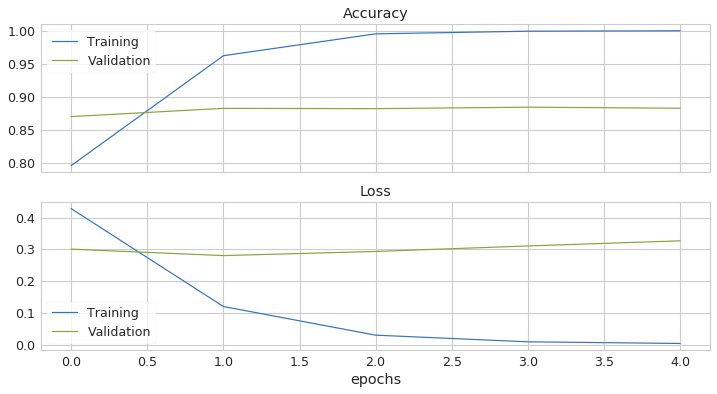

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ax1.plot(history.epoch, history.history['acc'], label='Training')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], label='Training')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.legend()

plt.show()